In [ ]:
import pandas as pd
import numpy as np
from warnings import filterwarnings
filterwarnings('ignore')
train = pd.read_csv('orange_small_churn_train_data.csv')
test = pd.read_csv('orange_small_churn_test_data.csv')
df = train.copy()

In [298]:
# Одно наблюдение было без метки в трейне
train = train[~train.labels.isna()]

In [299]:
train.labels.value_counts()

-1.0    16921
 1.0     1377
Name: labels, dtype: int64

Досыпем наблюдений класса отток

In [300]:
from sklearn.utils import shuffle

In [301]:
def oversampling(data):
    data_churn = data[data.labels == 1]
    data_No_churn = data[data.labels == -1]
    times_to_oversample = data_No_churn.shape[0] // data_churn.shape[0]
    data_to_append = data_churn
    for i in range(times_to_oversample):
        data_to_append = data_to_append.append(data_churn)
    data_No_churn = shuffle(data_No_churn.append(data_to_append))
    return data_No_churn

In [302]:
train = oversampling(train)

In [303]:
y = train.labels

Слепим общий датафрейм для чистки и заполнения пропусков

In [304]:
data = train.append(test)

In [305]:
data.shape

(44822, 232)

In [306]:
y

8906     1.0
11228    1.0
14929   -1.0
16949    1.0
14785   -1.0
        ... 
7345     1.0
6924    -1.0
16419    1.0
9273     1.0
2151     1.0
Name: labels, Length: 34822, dtype: float64

In [307]:
data.labels.value_counts()

 1.0    17901
-1.0    16921
Name: labels, dtype: int64

In [308]:
data = data.drop('labels',axis=1)

In [309]:
data = data.dropna(axis=1, thresh=2000)

In [310]:
data.shape

(44822, 78)

Заполним пропуски. Отдельно в категориальных и числовых фичах

In [311]:
qual_data = data.select_dtypes(include='object')
qual_data.fillna('None', inplace=True)

In [312]:
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [313]:
qual_data = MultiColumnLabelEncoder().fit_transform(qual_data)

In [314]:
quant_data = data.select_dtypes(exclude='object')

Числовые признаки заполним средним значением

In [315]:
num_means = quant_data.mean()
quant_data = quant_data.fillna(num_means)

Собираем обратно весь сет

In [316]:
all_data = pd.concat([qual_data,quant_data], axis=1, join='inner')

Делим обратно на train test

In [317]:
df_train = all_data.iloc[:len(y),:]
df_test = all_data.iloc[len(y):,:]
print(df_train.shape,y.shape,df_test.shape)

(34822, 78) (34822,) (10000, 78)


In [318]:
cols_to_drop = ['ID', 'Var201','Var160','Var22','Var208']
df_train = df_train.drop(cols_to_drop,axis=1)
df_test = df_test.drop(cols_to_drop,axis=1)

### Evaluation

In [319]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.33, random_state=42)

In [320]:
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
n_folds = 10

def f1_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    f1_score = cross_val_score(model, X_test.values, y_test, scoring="f1", cv = kf, n_jobs = -1)
    roc = cross_val_score(model, X_test.values, y_test, scoring="roc_auc", cv = kf, n_jobs = -1)
    return(f1_score, roc)

def f1_cv_SKF(model):
    skf = StratifiedKFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    f1_score = cross_val_score(model, X_test.values, y_test, scoring="f1", cv = skf, n_jobs = -1)
    roc = cross_val_score(model, X_test.values, y_test, scoring="roc_auc", cv = skf, n_jobs = -1)
    return(f1_score, roc)

### Modeing

In [321]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[100, 200, 500], 'max_depth':[5, 10, 20], 'n_jobs':[-1]}
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters)
clf.fit(X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [322]:
from sklearn.metrics import roc_curve, auc

In [323]:
from sklearn.metrics import f1_score, roc_auc_score

In [324]:
rfc = RandomForestClassifier()

In [325]:
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [326]:
f1_score, roc_score = f1_cv(rfc)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.9590 (0.0071)


 ROC_AUC score: 0.9916 (0.0032)



# Выполнение задания

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [32]:
# Код для отрисовки графиков learning curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(16,10))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


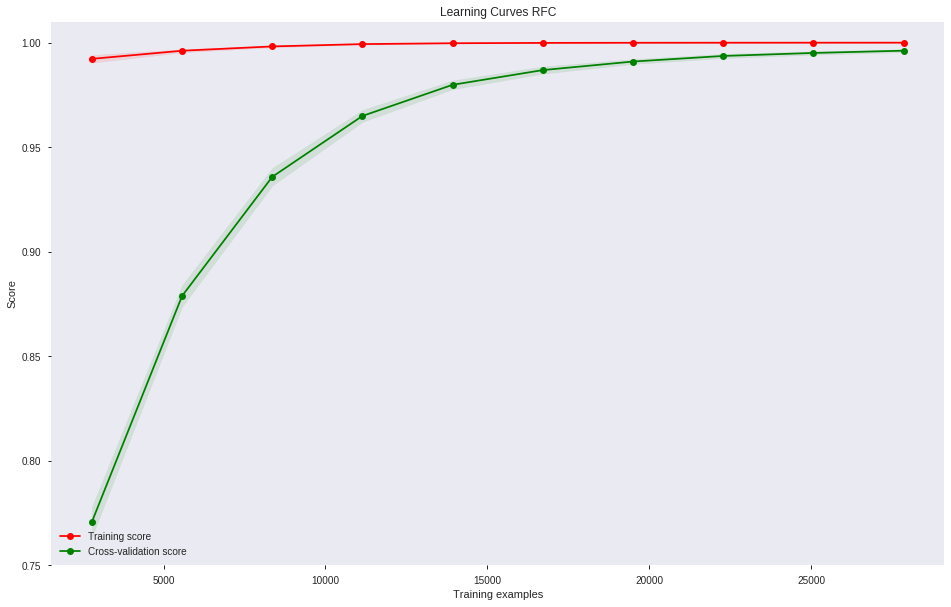

In [33]:
X, y = df_train, y

title = "Learning Curves RFC"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X, y, ylim=(0.75, 1.01), cv=cv, n_jobs= -1)
plt.show();

1\. Видно, что с ростом количества данных повышается качество модели. Сильного улучшения после 23000 уже не происходит.

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

Изначально в моей модели я использовал технику oversampling чтобы получить больше данных для обучения модели и сбалансировать выборку. При работе с выборкой с изначальным распределением классов качество классификатора очень низкое.

In [34]:
df_2 = df[~df.labels.isna()] # изначальная выборка

In [35]:
# Почистим и приведем выборку в такой же вид для обучения классификатора
y_2 = df_2.labels
data_2 = df_2.append(test)
data_2 = data_2.drop('labels',axis=1)
data_2 = data_2.dropna(axis=1, thresh=2000)
qual_data = data_2.select_dtypes(include='object')
qual_data.fillna('None', inplace=True)
qual_data = MultiColumnLabelEncoder().fit_transform(qual_data)
quant_data = data_2.select_dtypes(exclude='object')
num_means = quant_data.mean()
quant_data = quant_data.fillna(num_means)
all_data = pd.concat([qual_data,quant_data], axis=1, join='inner')
cols_to_drop = ['ID', 'Var201','Var160','Var22','Var208']
all_data = all_data.drop(cols_to_drop,axis=1)
df_train_2 = all_data.iloc[:len(y_2),:]
df_test_2 = all_data.iloc[len(y_2):,:]
print(df_train_2.shape,y_2.shape,df_test_2.shape)

(18298, 73) (18298,) (10000, 73)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(df_train_2, y_2, test_size=0.33, random_state=42)

In [37]:
rfc_2 = RandomForestClassifier()

In [38]:
rfc_2.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [39]:
f1_score, roc_score = f1_cv(rfc_2)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0165 (0.0202)


 ROC_AUC score: 0.5836 (0.0444)



Качество при обучении классификатора на исходных данных намного ниже, нежели при использовании oversapling'a

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [40]:
# Попробуем встроенные балансы весов
rfc_2_1 = RandomForestClassifier(class_weight='balanced')
rfc_2_1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [41]:
f1_score, roc_score = f1_cv(rfc_2_1)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.5894 (0.0415)



In [42]:
# ПОпробуем задать веса самостоятельно
rfc_2_1_2 = RandomForestClassifier(class_weight={-1:1,1:15})
rfc_2_1_2.fit(X_train,y_train)
f1_scor_e, roc_score = f1_cv(rfc_2_1_2)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.5821 (0.0491)



Опять получилось так, что задание весов не особо добавляет в качестве

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [43]:
def undersampling(data, alpha):
    dataChurn = data[data['labels'] == 1]
    dataNoChurn = data[data['labels'] == -1]
    countChurn = len(dataChurn)
    countNoChurn = len(dataNoChurn)
    np.random.seed(42)
    rands = np.random.randint(0,countNoChurn, countChurn*alpha)
    dataChurn = dataChurn.append(dataNoChurn.iloc[rands,:])
    dataChurn = shuffle(dataChurn)
    return dataChurn

Количество классо одинаково

In [44]:
df_2_2 = undersampling(df_2,1)

In [45]:
def create_data_frame(dataframe):
    y_ = dataframe.labels
    data_ = dataframe.append(test)
    data_ = data_.drop('labels',axis=1)
    data_ = data_.dropna(axis=1, thresh=2000)
    qual_data = data_.select_dtypes(include='object')
    qual_data.fillna('None', inplace=True)
    qual_data = MultiColumnLabelEncoder().fit_transform(qual_data)
    quant_data = data_.select_dtypes(exclude='object')
    num_means = quant_data.mean()
    quant_data = quant_data.fillna(num_means)
    all_data = pd.concat([qual_data,quant_data], axis=1, join='inner')
    cols_to_drop = ['ID', 'Var201','Var160','Var22','Var208']
    all_data = all_data.drop(cols_to_drop,axis=1)
    df_train_ = all_data.iloc[:len(y_),:]
    df_test_ = all_data.iloc[len(y_):,:]
    return df_train_, df_test_, y_

In [46]:
df_train_2_2, df_test_2_2, y_2_2 = create_data_frame(df_2_2)
X_train, X_test, y_train, y_test = train_test_split(df_train_2_2, y_2_2, test_size=0.33, random_state=42)

In [47]:
rfc_2_2 = RandomForestClassifier()
rfc_2_2.fit(X_train,y_train)
f1_scor_e, roc_score = f1_cv(rfc_2_2)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.6151 (0.0425)



Количество Класса не отток в 2 раза больше

In [48]:
df_2_2 = undersampling(df_2,2)

In [49]:
df_train_2_2, df_test_2_2, y_2_2 = create_data_frame(df_2_2)
X_train, X_test, y_train, y_test = train_test_split(df_train_2_2, y_2_2, test_size=0.33, random_state=42)

In [50]:
rfc_2_2 = RandomForestClassifier()
rfc_2_2.fit(X_train,y_train)
f1_scor_e, roc_score = f1_cv(rfc_2_2)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.6447 (0.0413)



Количество класса не отток в три раза больше

In [51]:
df_2_2 = undersampling(df_2,3)

In [52]:
df_train_2_2, df_test_2_2, y_2_2 = create_data_frame(df_2_2)
X_train, X_test, y_train, y_test = train_test_split(df_train_2_2, y_2_2, test_size=0.33, random_state=42)

In [53]:
rfc_2_2 = RandomForestClassifier()
rfc_2_2.fit(X_train,y_train)
f1_scor_e, roc_score = f1_cv(rfc_2_2)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.6512 (0.0400)



Увеличивается с увеличением класса не Отток, скорее всего модель имеет больше примеров для обучения и лучше отделяет оттко от не оттока

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [120]:
df_3 = df[~df.labels.isna()] # изначальная выборка

In [121]:
df_3 = df_3.select_dtypes(exclude='object') # Оставим только количественные переменные для этой части задания

In [122]:
X_train = df_3.drop('labels',axis=1).dropna(axis=1,how='all')
y_train = df_3.labels

In [123]:
X_train_mean = X_train.fillna(X_train.mean()) # Заполняем средним

In [124]:
rfc_3_1 = RandomForestClassifier()
rfc_3_1.fit(X_train_mean,y_train)
f1_scor_e, roc_score = f1_cv(rfc_3_1)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.6420 (0.0475)



In [125]:
X_train_median = X_train.fillna(X_train.median()) # Заполняем медианой

In [126]:
rfc_3_1 = RandomForestClassifier()
rfc_3_1.fit(X_train_median,y_train)
f1_scor_e, roc_score = f1_cv(rfc_3_1)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.6380 (0.0322)



Медиана чуть добавляет в качестве

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [128]:
df_4 = df[~df.labels.isna()] # изначальная выборка

In [129]:
df_4 = df_4.select_dtypes(include='object')

In [130]:
df_4 = df_4.fillna('None')

In [131]:
df_4 = MultiColumnLabelEncoder().fit_transform(df_4)

In [134]:
X_train = pd.concat([X_train_median, df_4],axis=1)

In [136]:
rfc_4_1 = RandomForestClassifier()
rfc_4_1.fit(X_train,y_train)
f1_scor_e, roc_score = f1_cv(rfc_3_1)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.6332 (0.0380)



Качество упало при использовании LabelEncoder'a 

In [175]:
df_5 = df[~df.labels.isna()] # изначальная выборка

In [176]:
df_5 = df_5.select_dtypes(include='object')

In [177]:
df_5 = df_5.fillna('None')
# посчитаем количество уникальных значений и отберем те, где меньше 250 уникальных
counts = pd.Series([len(df_5[df_5.columns[i]].value_counts()) for i in range(len(df_5.columns))], index = df_5.columns)
vars_2dummy = counts[counts <250].index
# составим дамми переменные
X3_dummy = pd.get_dummies(df_5[vars_2dummy])
# уберем дубликаты
X3_dummy = X3_dummy.T.drop_duplicates().T

In [178]:
X_train = pd.concat([X_train_median, X3_dummy],axis=1)

In [179]:
X_train.isna().sum().sum()

0

In [180]:
rfc_4_1 = RandomForestClassifier()
rfc_4_1.fit(X_train,y_train)
f1_scor_e, roc_score = f1_cv(rfc_3_1)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.6488 (0.0444)



Качество повысилось при использовании дамми!

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [161]:
from sklearn.feature_selection import SelectKBest, SelectFromModel

In [149]:
k100 = SelectKBest(k=100).fit(X_train,y_train)

In [151]:
k100

SelectKBest(k=100, score_func=<function f_classif at 0x7f3310cbff28>)

In [152]:
rfc_5 = RandomForestClassifier()
rfc_5.fit(X_train.loc[:,k100.get_support()],y_train)
f1_scor_e, roc_score = f1_cv(rfc_3_1)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.6405 (0.0403)



In [153]:
k200 = SelectKBest(k=200).fit(X_train,y_train)
rfc_5 = RandomForestClassifier()
rfc_5.fit(X_train.loc[:,k200.get_support()],y_train)
f1_scor_e, roc_score = f1_cv(rfc_3_1)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.6498 (0.0355)



In [154]:
k300 = SelectKBest(k=300).fit(X_train,y_train)
rfc_5 = RandomForestClassifier()
rfc_5.fit(X_train.loc[:,k300.get_support()],y_train)
f1_scor_e, roc_score = f1_cv(rfc_3_1)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.6211 (0.0576)



In [155]:
k250 = SelectKBest(k=250).fit(X_train,y_train)
rfc_5 = RandomForestClassifier()
rfc_5.fit(X_train.loc[:,k250.get_support()],y_train)
f1_scor_e, roc_score = f1_cv(rfc_3_1)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.6676 (0.0490)



In [156]:
k275 = SelectKBest(k=275).fit(X_train,y_train)
rfc_5 = RandomForestClassifier()
rfc_5.fit(X_train.loc[:,k275.get_support()],y_train)
f1_scor_e, roc_score = f1_cv(rfc_3_1)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.6357 (0.0409)



In [157]:
k263 = SelectKBest(k=263).fit(X_train,y_train)
rfc_5 = RandomForestClassifier()
rfc_5.fit(X_train.loc[:,k263.get_support()],y_train)
f1_scor_e, roc_score = f1_cv(rfc_3_1)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.6544 (0.0519)



In [158]:
k225 = SelectKBest(k=225).fit(X_train,y_train)
rfc_5 = RandomForestClassifier()
rfc_5.fit(X_train.loc[:,k225.get_support()],y_train)
f1_scor_e, roc_score = f1_cv(rfc_3_1)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.6543 (0.0427)



In [165]:
from sklearn.linear_model import Lasso

lsvc = Lasso(alpha = 0.1).fit(X_train,y_train)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X_train)
print(X_new.shape)

(18298, 6)


In [166]:
rfc_5 = RandomForestClassifier()
rfc_5.fit(X_new,y_train)
f1_scor_e, roc_score = f1_cv(rfc_3_1)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.6228 (0.0373)



In [171]:
from sklearn.linear_model import LogisticRegressionCV
# подбираем оптимальное значение коэффициента регуляризации
lr_l1 = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=3, scoring='roc_auc').fit(X_train, y_train)
X_lr = SelectFromModel(lr_l1, prefit=True).transform(X_train)
# осталось признаков
X_lr.shape[1]

52

In [172]:
rfc_5 = RandomForestClassifier()
rfc_5.fit(X_lr,y_train)
f1_scor_e, roc_score = f1_cv(rfc_3_1)
print("\n f1 score: {:.4f} ({:.4f})\n".format(f1_score.mean(), f1_score.std()))
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 f1 score: 0.0084 (0.0168)


 ROC_AUC score: 0.6319 (0.0380)



Лассо выкидывает много признаков, классификатор не очень много выкинул, хотя качество не особо отличается. НАилучшее качество получилось при 250 фичах

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

Соберем датасет для поиска параметров. Для случайного леса у меня лучше работало оверсэмплинг и медианы с дамми кодированием.

In [360]:
df_6 = df[~df.labels.isna()]

In [361]:
df_6 = df_6.dropna(axis=1, thresh=2000)
df_6 = df_6.drop('ID',axis=1)

In [362]:
df_6_qual = df_6.select_dtypes(include='object')
df_6_qual = df_6_qual.fillna('None')
# посчитаем количество уникальных значений и отберем те, где меньше 250 уникальных
counts = pd.Series([len(df_6_qual[df_6_qual.columns[i]].value_counts()) for i in range(len(df_6_qual.columns))], index = df_6_qual.columns)
vars_2dummy = counts[counts <250].index
# составим дамми переменные
X6_dummy = pd.get_dummies(df_6_qual[vars_2dummy])
# уберем дубликаты
X6_dummy = X6_dummy.T.drop_duplicates().T

In [363]:
df_6 = df_6.select_dtypes(exclude='object') # Оставим только количественные переменные для этой части задания
X_train = df_6.drop('labels',axis=1).dropna(axis=1,how='all')
X_train_median = X_train.fillna(X_train.median())

In [364]:
y_train = df_6.labels

In [365]:
X_train = pd.concat([X_train_median,X6_dummy],axis=1)

In [366]:
rfc_5 = RandomForestClassifier()
rfc_5.fit(X_train,y_train)
f1_scor_e, roc_score = f1_cv(rfc_3_1)
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 ROC_AUC score: 0.9930 (0.0022)



Пользовался статьей Дьяконова: https://dyakonov.org/2016/11/14/%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B9-%D0%BB%D0%B5%D1%81-random-forest/

In [418]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200], 
              'max_depth':[5, 10, 20, 50], 
              'n_jobs':[-1],
              'random_state':[42]
             }
rfc = RandomForestClassifier()
clf = GridSearchCV(rfc, parameters, scoring = 'roc_auc')
clf.fit(X_train,y_train)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [419]:
pd.DataFrame(clf.cv_results_).ix[:, :7]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,param_n_jobs
0,0.771663,0.682798,0.117793,0.001468,5,100,-1
1,0.280802,0.011799,0.116857,0.000713,5,110,-1
2,0.298580,0.007686,0.116855,0.000327,5,120,-1
3,0.314538,0.012033,0.116632,0.000802,5,130,-1
4,0.313811,0.008791,0.117360,0.000218,5,140,-1
5,0.337580,0.009525,0.117047,0.001043,5,150,-1
6,0.348415,0.009197,0.116955,0.000482,5,160,-1
7,0.362568,0.013396,0.119108,0.003106,5,170,-1
8,0.366528,0.015560,0.118423,0.002871,5,180,-1
9,0.384821,0.015719,0.117164,0.000178,5,190,-1


In [420]:
clf.best_params_

{'max_depth': 5, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 42}

In [421]:
rfc_5 = RandomForestClassifier(max_depth=5,n_estimators=100)
rfc_5.fit(X_train,y_train)
f1_scor_e, roc_score = f1_cv(rfc_3_1)
print("\n ROC_AUC score: {:.4f} ({:.4f})\n".format(roc_score.mean(), roc_score.std()))


 ROC_AUC score: 0.9920 (0.0022)



7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [391]:
def featureImportance(estimator, data):
    fig = plt.figure(figsize=(20, 70))
    ax = fig.add_subplot(111)

    df_f = pd.DataFrame(estimator.feature_importances_, columns=["importance"])
    df_f["labels"] = data.columns.values
    df_f.sort_values("importance", inplace=True, ascending=False)
    display(df_f.head(90))

    index = np.arange(90)
    bar_width = 0.5
    rects = plt.barh(index , df_f["importance"][:90], bar_width, alpha=0.4, color='b', label='Main')
    plt.yticks(index, df_f["labels"])
    plt.show()
    return df_f

,importance,labels
649,0.320620,probability
647,0.304936,labels
28,0.024595,Var126
41,0.022103,Var189
546,0.020631,Var218_None
...,...,...
600,0.000711,Var226_me1d
379,0.000694,Var204_WIr3
577,0.000688,Var223_M_8D
460,0.000682,Var207_GjJ35utlTa_GNSvxxpb9ju


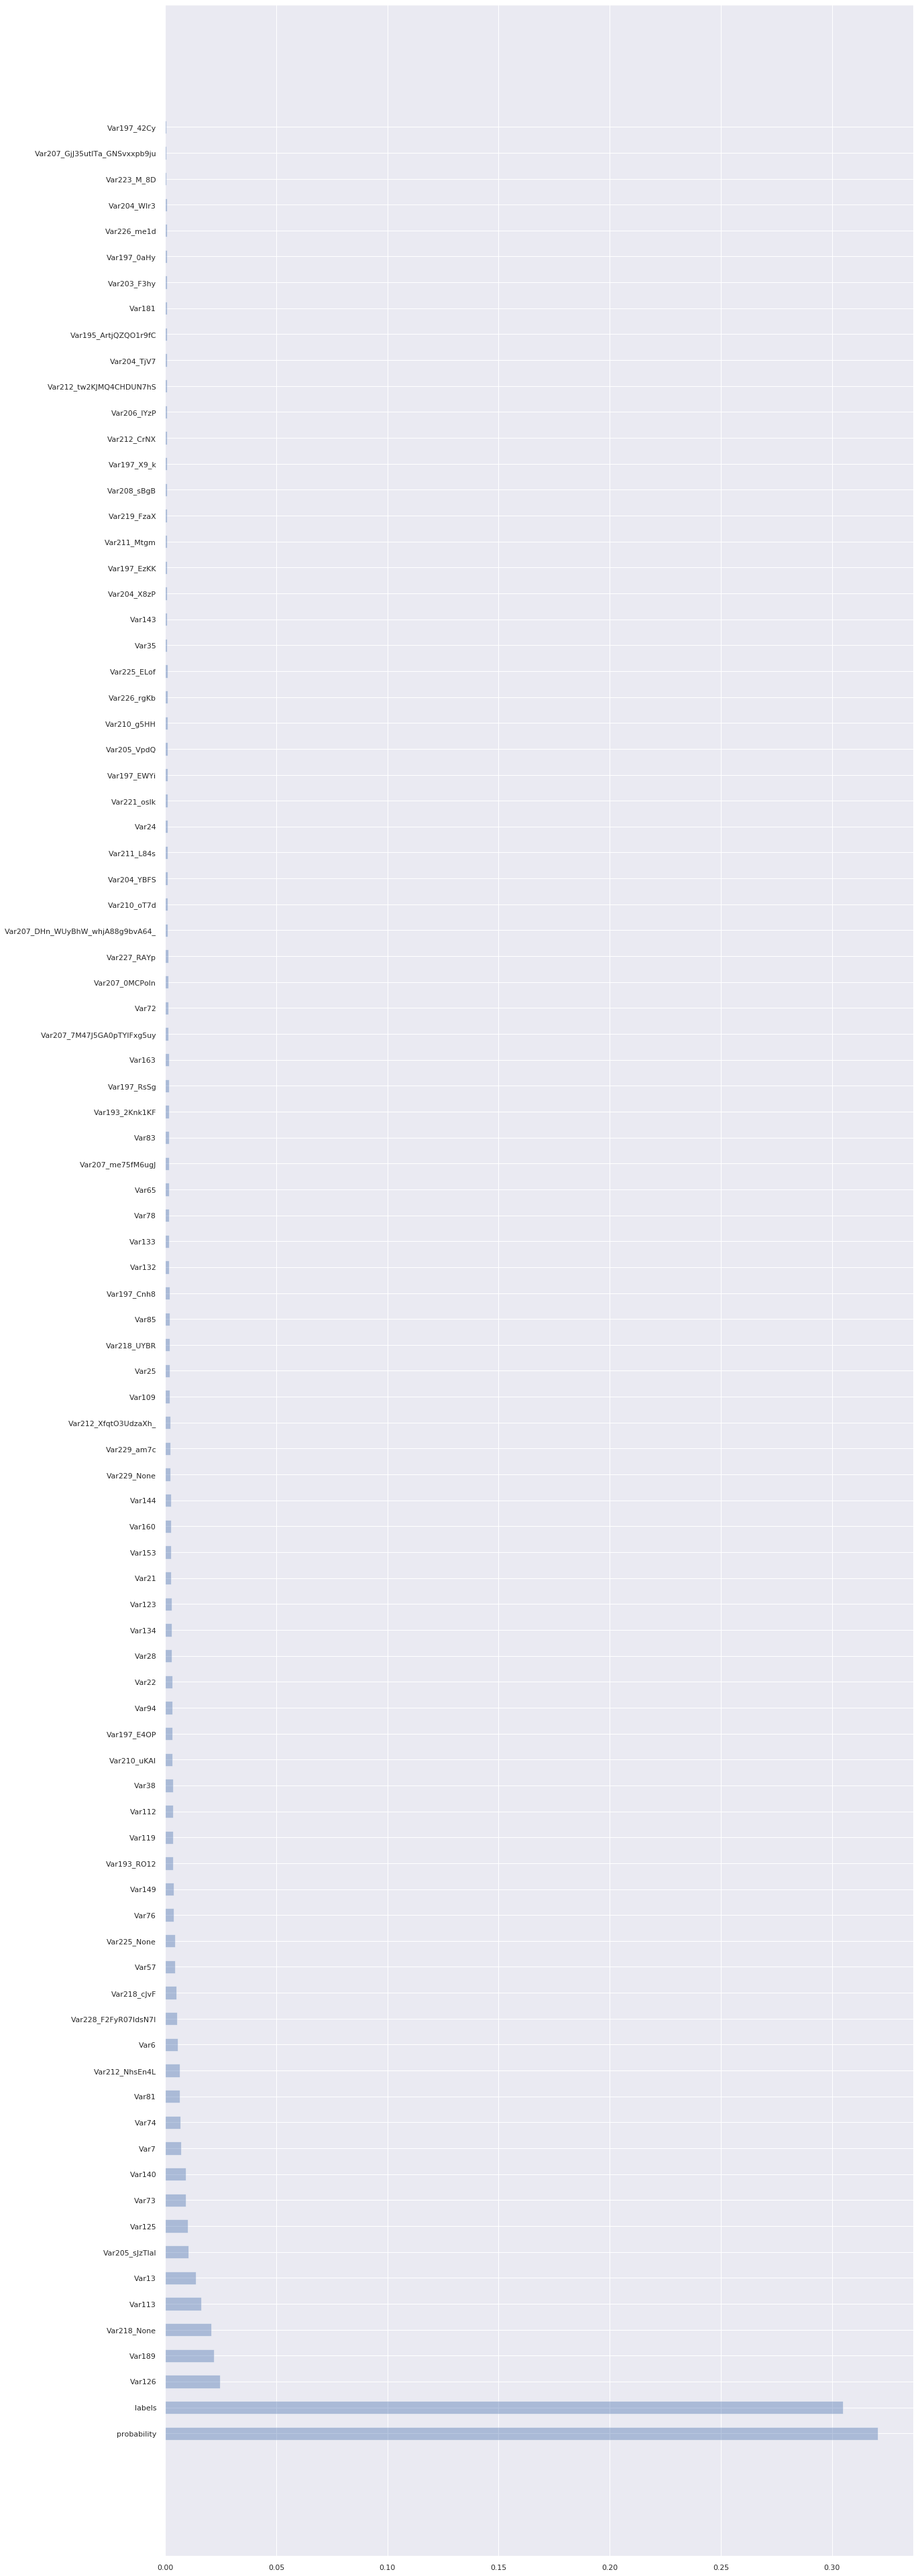

In [392]:
important_features = featureImportance(rfc_5, X_train)

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

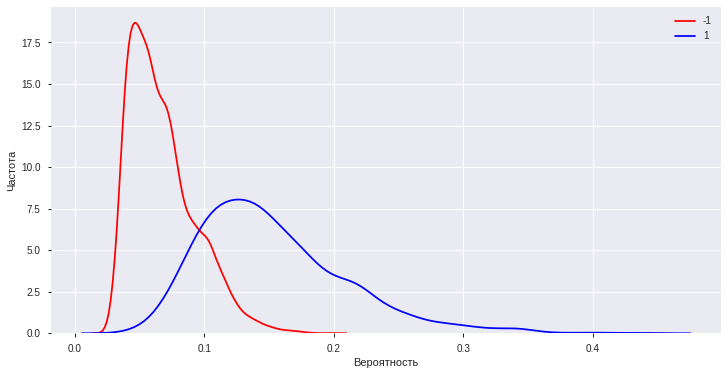

In [377]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 6))
pred = pd.Series(clf.best_estimator_.predict_proba(X_train)[:,1])
# гистограмма отклонений от истинных значений
sns.kdeplot(pred[y_train == -1], color = 'r', ax=ax, label=-1)
sns.kdeplot(pred[y_train == 1], color = 'b', ax=ax, label=1)
plt.ylabel(u'Частота')
plt.xlabel(u'Вероятность')
plt.show()

In [378]:
idx_low = pred[(pred < 0.1) & (y_train == 1)].index
idx_high = pred[(pred > 0.1) & (y_train == 1)].index

means_low = X_train.ix[idx_low, (clf.best_estimator_.feature_importances_ != 0).tolist()].mean()
means_high = X_train.ix[idx_high, (clf.best_estimator_.feature_importances_ != 0).tolist()].mean()

diff = pd.DataFrame(dict(means_low = means_low, means_high = means_high))
diff['abs_diff'] = abs(diff['means_high'] - diff['means_low'])
diff.sort_values('abs_diff', ascending=False)[:15]

,means_low,means_high,abs_diff
Var38,1.902903e+06,2.697135e+06,794232.292091
Var153,6.125355e+06,6.565318e+06,439962.596343
Var133,1.978435e+06,2.343825e+06,365389.392666
Var113,-2.666114e+05,4.974723e+04,316358.620297
Var76,1.268827e+06,1.544521e+06,275694.202889
Var149,1.981238e+05,3.167922e+05,118668.382945
Var163,4.046012e+05,5.081067e+05,103505.439254
Var81,8.072062e+04,1.196116e+05,38891.009620
Var134,4.194832e+05,4.477658e+05,28282.548308
Var94,7.383382e+04,6.594403e+04,7889.798058


Нормально делится с последней итерацией по заполнению признаков медианой и дамми.

In [379]:
data_with_predict = X_train
data_with_predict['labels'] = y_train

In [382]:
rfc_5.fit(X_train,y_train)
data_with_predict['predicted'] = rfc_5.predict(X_train)
data_with_predict['probability'] = rfc_5.predict_proba(X_train)[:,0]

In [404]:
# возвращает объекты, на которых совершены ошибки первого и второго рода
# параметры thresh_1 и thresh_2 - пороги для объектов, на которых модель совершила наибольшую ошибку
def errorObjects(data, thresh_1, thresh_2):
    df_first_type_err = pd.DataFrame([])
    df_second_type_err = pd.DataFrame([])
    for sample in range(len(data)):
        if (data['labels'][sample] == 1.0) and (data['predicted'][sample] == -1.0):
            if abs(1-data['probability'][sample]) > thresh_1:
                df_first_type_err = df_first_type_err.append(data.loc[sample])
        if (data['labels'][sample] == -1.0) and (data['predicted'][sample] == 1.0):
            if abs(data['probability'][sample]) > thresh_2:
                df_second_type_err = df_second_type_err.append(data.loc[sample])
    print('size of first type error samples: ' + str(len(df_first_type_err)))
    print('size of second type error samples: ' + str(len(df_second_type_err)))
    return(df_first_type_err, df_second_type_err)

In [415]:
first_type_err, second_type_err = errorObjects(data_with_predict, 0.3, 0.001)

size of first type error samples: 289
size of second type error samples: 0


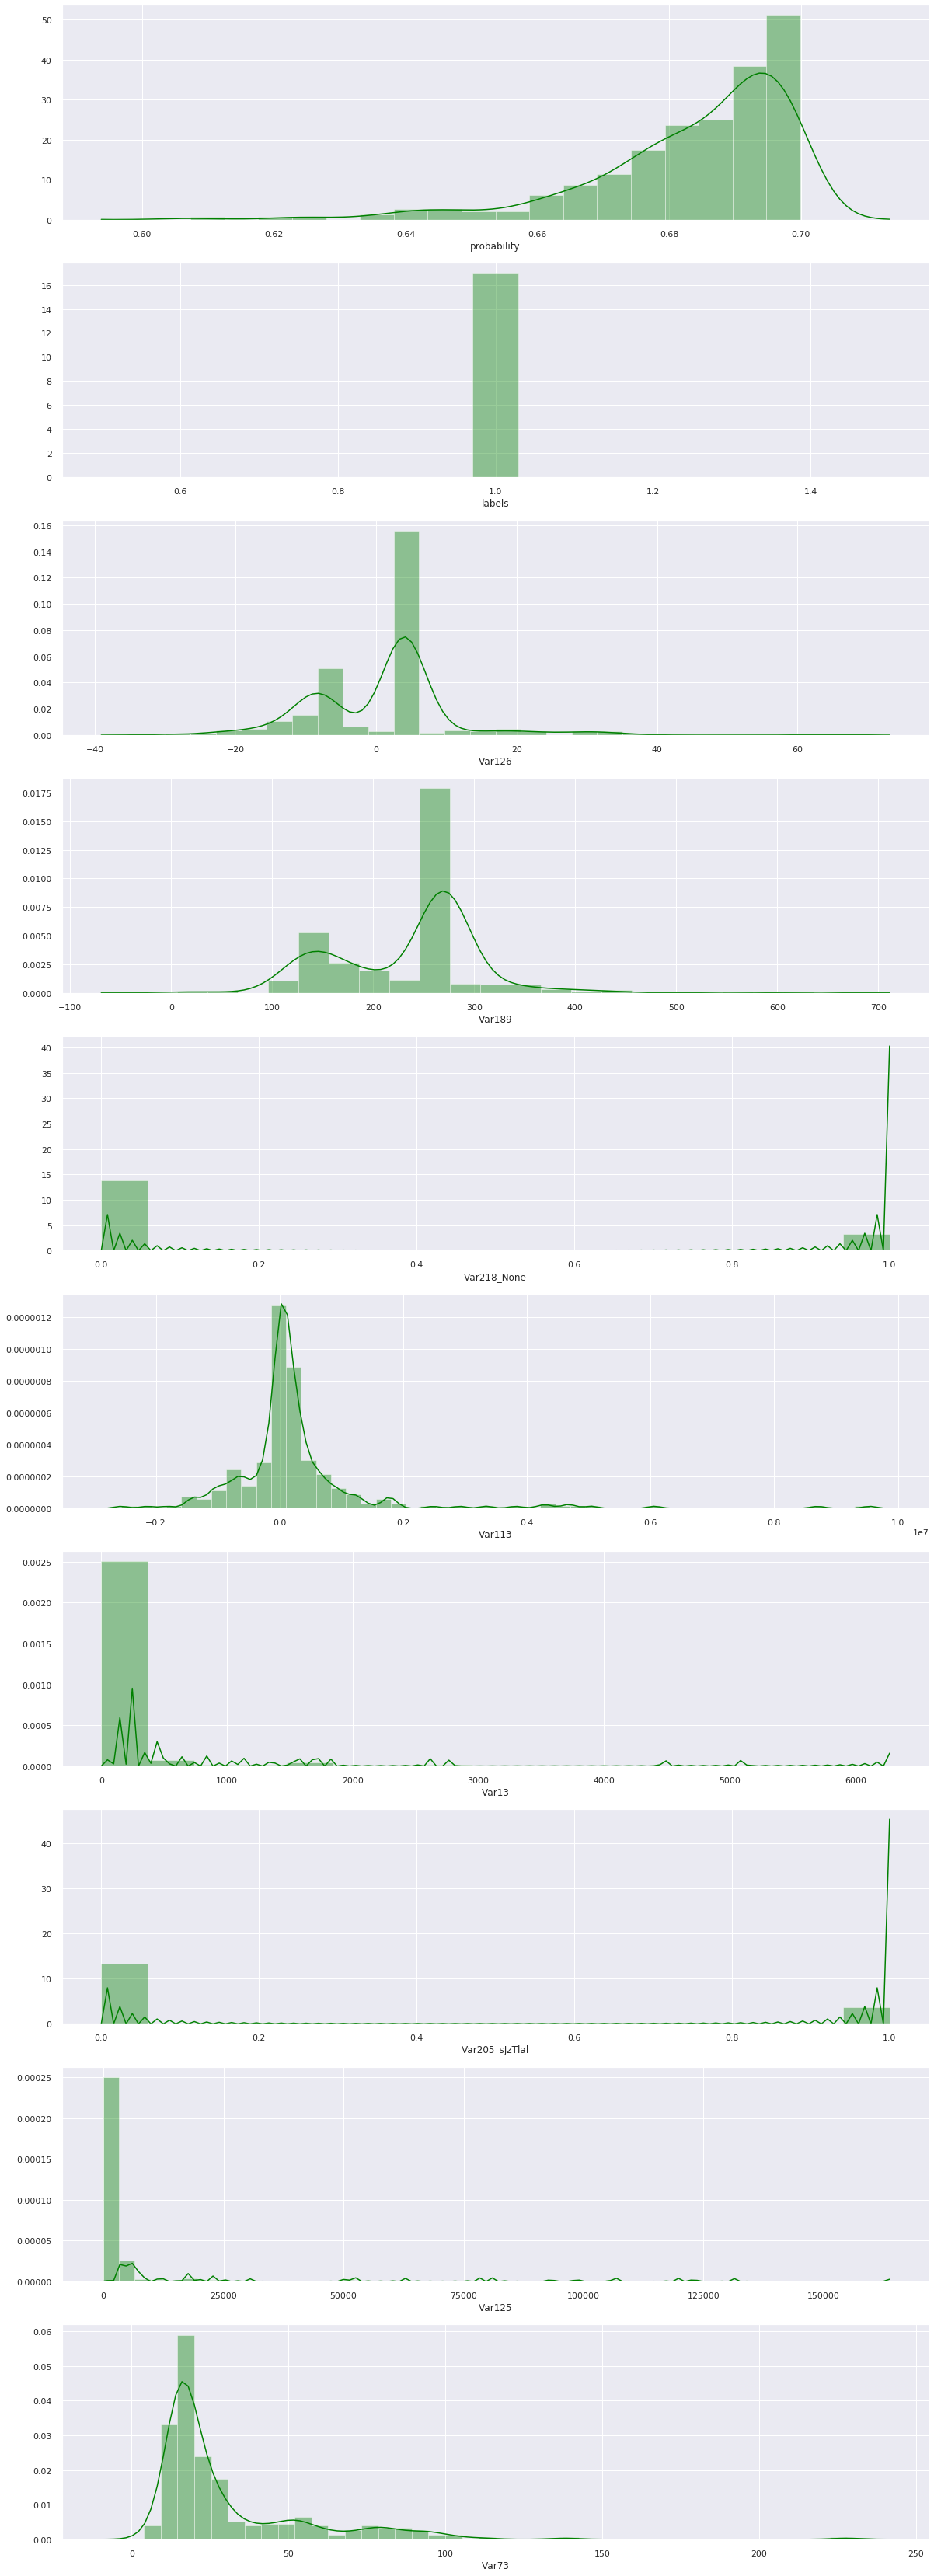

In [417]:
fig, axs = plt.subplots(10, figsize = (20,60))
sns.set(color_codes=True)
for ax, column in zip(axs,  important_features.iloc[:10,1]):
    sns.distplot(first_type_err[column][y_train == 1], ax = ax, color = "green", label = str(column)+" label = 1")
#     sns.distplot(second_type_err[column][y_data['labels'] == -1], ax = ax, color = "orange", label = str(column)+" label = -1")

Объекты, на которых получилась ошибка можно по некоторым фичам соотнести воедино, но и есть фичи, по котрым можно их отделить, можно потюнить еще параметры леса, либо исключить фичи, например Var218_None - это фича со значением None?! 

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

Финальная модель - Случайный лес с подбором параметров по сетке. с использованием дамми и заполнением пропусков медианой

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Можно заюзать стекинг: https://dyakonov.org/2019/04/19/%d0%b0%d0%bd%d1%81%d0%b0%d0%bc%d0%b1%d0%bb%d0%b8-%d0%b2-%d0%bc%d0%b0%d1%88%d0%b8%d0%bd%d0%bd%d0%be%d0%bc-%d0%be%d0%b1%d1%83%d1%87%d0%b5%d0%bd%d0%b8%d0%b8/